# FIGURE 2

In [1]:
import numpy as np
import pandas as pd
import math
from sklearn.cross_decomposition import PLSRegression
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from msresist.parameter_tuning import kmeansPLSR_tuning
from msresist.plsr import MeasuredVsPredicted_LOOCVplot, Q2Y_across_components, R2Y_across_components
from msresist.clustering import MyOwnKMEANS
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
from msresist.pre_processing import preprocessing
from FileExporter import create_download_link
import warnings
warnings.simplefilter("ignore")

### Importing and Pre-processing Data

### Phosphorylation measurements:

In [2]:
ABC_mc = preprocessing(motifs=True, Vfilter=True, FCfilter=True, log2T=True)

header = ABC_mc.columns
treatments = ABC_mc.columns[2:]

data = ABC_mc.iloc[:,2:].T
protnames = list(ABC_mc.iloc[:,1])
seqs = list(ABC_mc.iloc[:,0])

In [3]:
ABC_mc.shape

(393, 12)

### Phenotypes

#### Cell Viability:

% Confluency:

In [4]:
Y_cv = pd.read_csv('./msresist/data/Phenotypic_data/CV_raw3.csv').iloc[:30, :11]

Optionally take the fold-change to t=0:

In [5]:
# Y_cv.iloc[:, 1:] = Y_cv.iloc[:, 1:].div(Y_cv.iloc[0, 1:], axis = 1)

Define time-point of interest:

In [6]:
Y_cv = Y_cv[Y_cv["Elapsed"] == 87].iloc[0, 1:11]

## 1. Cross-validation

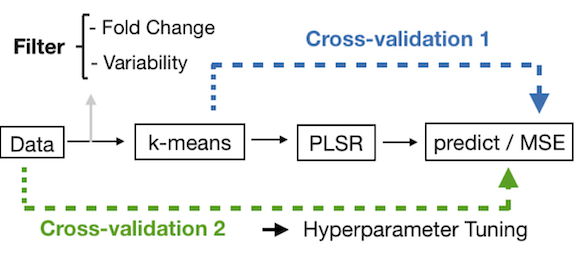

In [7]:
from IPython.display import Image
Image(filename='Model_pipeline.jpg')

### 1.1 Strategy 1: R2Y/Q2Y after k-means clustering (k=5)

Cross-validation fitting averages of k-means clusters into the PLSR model. Number of clusters must be set in advance:

In [20]:
ncl = 3

In [21]:
kmeans = MyOwnKMEANS(ncl).fit(data, Y_cv)
centers = kmeans.transform(data)

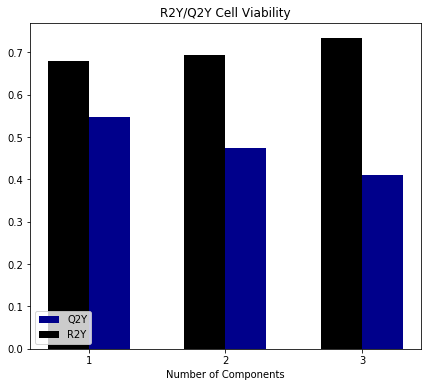

In [22]:
maxComp = ncl
Q2Y = Q2Y_across_components(centers, Y_cv, maxComp+1)
R2Y = R2Y_across_components(centers, Y_cv, maxComp+1)

range_ = np.linspace(1,maxComp,maxComp)

fig, axs = plt.subplots(1,1,figsize=(7,6))
plt.setp(axs, xticks=range_)
plt.bar(range_+0.15,Q2Y,width=0.3,align='center',label='Q2Y', color = "darkblue")
plt.bar(range_-0.15,R2Y,width=0.3,align='center',label='R2Y', color = "black")
plt.title("R2Y/Q2Y Cell Viability")
plt.xlabel("Number of Components")
plt.legend(loc=3)

### 1.2 Strategy 2: Gridsearch

Cross-validation fitting averages of k-means clusters into the PLSR model. Simulatenous tuning of number of clusters and number of components using GridSearch:

In [11]:
CVresults_max, CVresults_min, best_params = kmeansPLSR_tuning(data, Y_cv)
CVresults_min.nlargest(20, "mean_test_scores")

,#Clusters,#Components,mean_test_scores,mean_train_scores
2,3,1,-301.869908,-196.730402
14,6,1,-310.175158,-203.449349
9,5,1,-329.810308,-205.813656
27,8,1,-333.452158,-199.148232
44,10,1,-336.198285,-191.775286
5,4,1,-338.462537,-206.899612
35,9,1,-338.606277,-203.729481
20,7,1,-340.050889,-200.204283
65,12,1,-342.279974,-196.976252
104,15,1,-343.983855,-187.309151


In [67]:
twoC = CVresults_min.iloc[:2, :]
CVresults_min.iloc[:20, :]

,#Clusters,#Components,mean_test_scores,mean_train_scores
0,2,1,-480.071830,-218.395270
1,2,2,-363.798953,-192.906357
2,3,1,-301.869908,-196.730402
3,3,2,-363.758412,-185.850671
4,3,3,-568.737616,-154.012026
5,4,1,-338.462537,-206.899612
6,4,2,-365.706805,-190.247915
7,4,3,-514.171265,-175.718125
8,4,4,-476.453367,-139.154625
9,5,1,-329.810308,-205.813656


## 2. Model Predicted vs Actual for best Hyperparameter Set

In [152]:
ncl, ncomp = 4, 2

### 2.1 With CV Strategy 1:

Pearson's R:  0.7052935004094154 
 p-value:  0.022703547260319534


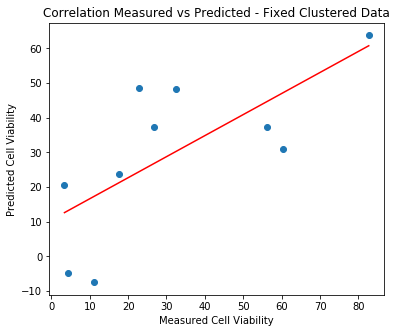

In [48]:
fig, axs = plt.subplots(1,1,figsize=(6,5))
MeasuredVsPredicted_LOOCVplot(centers, Y_cv, PLSRegression(ncomp), fig, "none", axs)
plt.title("Correlation Measured vs Predicted - Fixed Clustered Data")
plt.xlabel("Measured Cell Viability")
plt.ylabel("Predicted Cell Viability");

### 2.2 With CV Strategy 2:

In [153]:
estimators = [('kmeans', MyOwnKMEANS(ncl)), ('plsr', PLSRegression(ncomp))]
kmeans_plsr = Pipeline(estimators)

In [154]:
X_scores, Y_scores = kmeans_plsr.fit_transform(data, Y_cv)
PC1_scores, PC2_scores = X_scores[:, 0], X_scores[:, 1]
PC1_xload, PC2_xload = kmeans_plsr.named_steps.plsr.x_loadings_[:, 0], kmeans_plsr.named_steps.plsr.x_loadings_[:, 1]
PC1_yload, PC2_yload = kmeans_plsr.named_steps.plsr.y_loadings_[:, 0], kmeans_plsr.named_steps.plsr.y_loadings_[:, 1]

Pearson's R:  0.6461854089993254 
 p-value:  0.04352641714957421


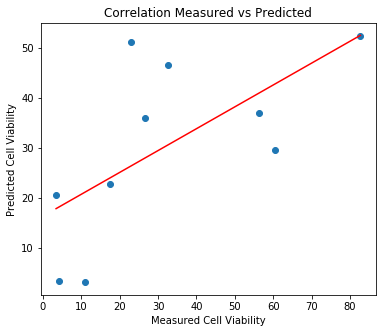

In [155]:
fig, axs = plt.subplots(1,1,figsize=(6,5))
MeasuredVsPredicted_LOOCVplot(data, Y_cv, kmeans_plsr, fig, "none", axs)

## 3. PLSR scores and loadings 

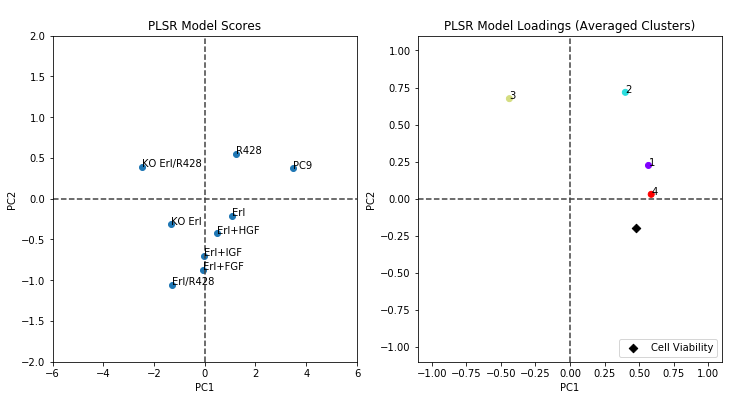

In [156]:
fig, axs = plt.subplots(1, 2,figsize=(12,6))

colors_ = cm.rainbow(np.linspace(0, 1, ncl))


axs[0].scatter(PC1_scores,PC2_scores)
for j, txt in enumerate(treatments):
    axs[0].annotate(txt, (PC1_scores[j], PC2_scores[j]))
axs[0].set_title('PLSR Model Scores')
axs[0].set_xlabel('PC1')
axs[0].set_ylabel('PC2')
axs[0].axhline(y=0, color='0.25', linestyle='--')
axs[0].axvline(x=0, color='0.25', linestyle='--')
axs[0].set_xlim([-6, 6])
axs[0].set_ylim([-2, 2])

numbered=[]
list(map(lambda v: numbered.append(str(v+1)), range(ncl)))

for i, txt in enumerate(numbered):
    axs[1].annotate(txt, (PC1_xload[i], PC2_xload[i]))
axs[1].scatter(PC1_xload, PC2_xload, c=np.arange(ncl), cmap=colors.ListedColormap(colors_))
axs[1].scatter(PC1_yload, PC2_yload, color='#000000', marker='D', label='Cell Viability')
axs[1].legend(loc=4)
axs[1].set_title('PLSR Model Loadings (Averaged Clusters)')
axs[1].set_xlabel('PC1')
axs[1].set_ylabel('PC2')
axs[1].axhline(y=0, color='0.25', linestyle='--')
axs[1].axvline(x=0, color='0.25', linestyle='--')
axs[1].set_xlim([-1.1, 1.1])
axs[1].set_ylim([-1.1, 1.1]);

In [60]:
clustermembers = kmeans_plsr.named_steps.kmeans.clustermembers(ABC_mc.T)
clustermembers

,Cluster_1,seqs_Cluster_1,Cluster_2,seqs_Cluster_2,Cluster_3,seqs_Cluster_3,Cluster_4,seqs_Cluster_4
0,"1-phosphatidylinositol 4,5-bisphosphate phosph...",RNPGFyVEANP,182 kDa tankyrase-1-binding protein,GPPARsPSQDF,14-3-3 protein zeta/delta,LLSVAyKNVVG,ERBB receptor feedback inhibitor 1,VSSTHyYLLPE
1,"10 kDa heat shock protein, mitochondrial",PEYGGtKVVLD,60S acidic ribosomal protein P2,yVASYL,"Actin, cytoplasmic 1",ISKQEyDESGP,Epidermal growth factor receptor,AENAEyLRVAP
2,14-3-3 protein epsilon,GDYHRyLAEFA,60S ribosomal protein L22-like 1,TYELRyFQISQ,Adapter molecule crk,QEEAEyVRALF,Epidermal growth factor receptor,QDPHStAVGNP
3,ADP-ribosylation factor 4,KTTILyKLKLG,ADP/ATP translocase 2,ANVIRyFPTQA,Afadin,TYTREyFTFPA,Epidermal growth factor receptor,SFLQRySSDPT
4,ADP-ribosylation factor-like protein 11,KTTLLyKLKGH,ARF GTPase-activating protein GIT1,GADSDyENTQS,Annexin A2,DARDLyDAGVK,SHC-transforming protein 1,FDDPSyVNVQN
5,ARF GTPase-activating protein GIT1,DDQHDyDSVAs,Actin-related protein 3,EPEDHyFLLTE,Annexin A8,DAETLyKAMKG,Transmembrane protein 230,STDDGyIDLQF
6,ATPase WRNIP1,AGEEHyNCISA,"Adenylate kinase 2, mitochondrial",AAEPEyPKGIR,Anoctamin-1,RVNEKySTLPA,NaN,NaN
7,Abl interactor 1,NTPYKtLEPVK,Breast cancer anti-estrogen resistance protein 1,PAPDLyDVPPG,Argininosuccinate synthase,LKGQVyILGRE,NaN,NaN
8,Abl interactor 2,VVPNDyVPSPT,Choline-phosphate cytidylyltransferase A,AAYDIsEDEED,BAG family molecular chaperone regulator 3,HQAQKtHYPAQ,NaN,NaN
9,Actin filament-associated protein 1-like 2,DEEYIyMNKVT,Cyclin-dependent kinase 1,PIRVYtHEVVT,BAG family molecular chaperone regulator 3,THQPVyHKIQG,NaN,NaN


#### Cluster Averages across Conditions

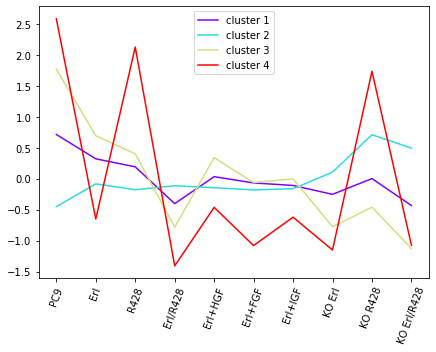

In [61]:
fig = plt.figure(figsize=(7,5))

centers = kmeans_plsr.named_steps.kmeans.transform(data).T

for i in range(centers.shape[0]):
    plt.plot(centers.iloc[i,:], label = "cluster "+str(i+1), color = colors_[i])
    
plt.legend()
plt.xticks(np.arange(centers.shape[1]), (treatments), rotation=70);